In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
%matplotlib inline

import time
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import torch


from gym.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
from gym.envs.toy_text import frozen_lake, discrete

import gym
from gym.envs.registration import register

register(
    id='D4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False})


""" 
    env: gym.core.Environment
    Environment to play on.

    env.P: dictionary
    It is from gym.core.Environment
    P[state][action] is tuples with (probability, nextstate, reward, terminal)
    
    env.nS: int
    count of states 
    
    env.nA: int
    count of actions available
    
    action_space: discrete
                LEFT = 0
                DOWN = 1
                RIGHT = 2
                UP = 3
    ENVIRONMENT: 
                "SFFF",
                "FHFH",
                "FFFH",
                "HFFG"
"""

def print_policy(policy, action_names):
    """ 
    Print the policy in human-readable format.
    """
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)

    print(str_policy[0:4])
    print(str_policy[4:8])
    print(str_policy[8:12])
    print(str_policy[12:16])
    
    return str_policy

action_names = {LEFT: 'LEFT', RIGHT: 'RIGHT', DOWN: 'DOWN', UP: 'UP'}

In [3]:
env = gym.make('D4x4-FrozenLake-v0')
grid = 4
gamma = 0.9 # Change this to play with it

In [4]:
def fancy_visual(value_func,policy_str):
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter=0
    for j in range(0, 4):
        for i in range(0, 4):
            if policy_str[counter]=="DOWN":
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_str[counter]=="UP":
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_str[counter]=="LEFT":
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')


Doing Policy Iteration
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0] [5.92496469e-01 6.58106469e-01 7.31006469e-01 6.58106469e-01
 6.58106469e-01 1.76921114e-03 8.12006469e-01 6.03381864e-04
 7.31006469e-01 8.12006469e-01 9.02006469e-01 1.58116958e-04
 1.73945442e-03 9.02006469e-01 1.00200647e+00 2.00646897e-03] 6 46
Total time taken: 0.030454635620117188
Total Policy Improvement Steps: 6
Total Policy Evaluation Steps: 46
Policy:
['DOWN' 'RIGHT' 'DOWN' 'LEFT']
['DOWN' 'LEFT' 'DOWN' 'LEFT']
['RIGHT' 'DOWN' 'DOWN' 'LEFT']
['LEFT' 'RIGHT' 'RIGHT' 'LEFT']


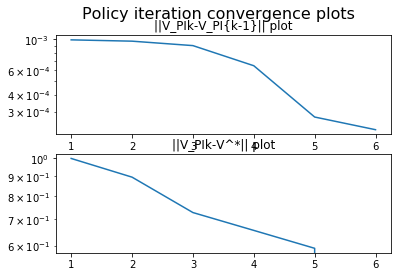

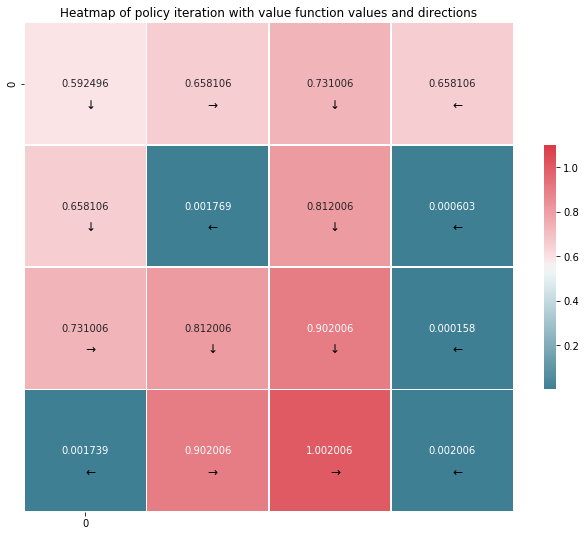

In [7]:
########################################################################
######################### Policy iteration #############################
########################################################################


def policy_evaluation(env, gamma, policy, value_func_old, max_iterations=int(1e3), tol=1e-3):
    """
        Evaluate the value of a policy.
        See section 4.1 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))

    for iteration in range(max_iterations):
        
        delta=0
        
        for s in range(env.nS):
            value_func_temp = 0
            a = policy[s]
            
            # Using env.P[s][a] implement the V(s) updation given in Figure 4.1
            # Note: Since this is a deterministic policy, the summation over
            # action space is not required.
            for next_state_from_tpm in env.P[s][a]:
                prob_action = next_state_from_tpm[0]
                cur_reward=next_state_from_tpm[2]
                future_reward=gamma*value_func_old[next_state_from_tpm[1]]
                value_func_temp+=prob_action*(cur_reward+future_reward)
            
            diff=abs(value_func_old[s]-value_func_temp)
            delta=max(delta,diff)
            
            value_func_new[s]=value_func_temp
        
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some tolerance level(it's 1e-3 here).
        if delta<=tol: break
        
        value_func_old = value_func_new
        value_func_collect[:,iteration] = value_func_old

    return delta, value_func_new, iteration



def policy_improvement(env, gamma, value_func, policy):
    """
      Given a policy and value function, improve the policy.
      Returns true if policy is unchanged. Also returns the new policy.
      See section 4.2 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    value_func_new = np.zeros(env.nS)
    policy_stable=True
    for s in range(env.nS):
        old_action=policy[s]
        max_value_func=-1
        max_action=-1
        for a in range(env.nA):
            value_func_temp=0
            # Copy and paste the "sum" which you've implemented in the 
            # policy_evaluation function here.
            for next_state_from_tpm in env.P[s][a]:
                prob_action = next_state_from_tpm[0]
                cur_reward = next_state_from_tpm[2]
                future_reward = gamma * value_func[next_state_from_tpm[1]]
                value_func_temp+=prob_action * (cur_reward + future_reward)
            
            if value_func_temp>max_value_func:
                max_value_func=value_func_temp
                max_action=a
        if max_action!=old_action: policy_stable=False
        policy[s]=max_action
        value_func_new[s]=max_value_func
    return policy_stable, policy, value_func_new


def policy_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """
       Runs policy iteration.
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
       See section 4.3 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    policy = np.random.randint(4, size=env.nS)
    value_func_old = np.random.rand(env.nS)
    value_func = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))
    delta_collect = np.zeros(max_iterations)
    policy_stable=False
    iters=0
    eval_iters=0
    while not policy_stable:
        delta,value_func,iter=policy_evaluation(env,gamma,policy,value_func_old)
        delta_collect[iters] = delta
        value_func_collect[:,iters] = value_func
        eval_iters+=iter
        policy_stable,policy,value_func_old=policy_improvement(env,gamma,value_func,policy)
        iters+=1

    temp=np.repeat(value_func_collect[:,iters-1], iters, axis=0) 
    temp=temp.reshape(16,iters)
    temp1 = abs(value_func_collect[:,0:iters]-temp)
    distance_from_converged_value_func = temp1.max(axis=0)

    fig = plt.figure()
    fig.suptitle("Policy iteration convergence plots", fontsize=16)
    ax = plt.subplot(2,1,1)
    ax.plot(range(1,iters+1),delta_collect[0:iters])
    ax.set_title('||V_PIk-V_PI{k-1}|| plot')
    ax.set_yscale('log')


    ax = plt.subplot(2,1,2)
    ax.plot(range(1,iters+1),distance_from_converged_value_func)
    ax.set_title('||V_PIk-V^*|| plot')
    ax.set_yscale('log')

    print(policy, value_func, iters, eval_iters)
    return policy, value_func, iters, eval_iters


print("Doing Policy Iteration")
start_time=time.time()
policy, value_func, policy_iters, val_iters= policy_iteration(env,gamma)
print("Total time taken: "+str((time.time()-start_time)))
print("Total Policy Improvement Steps: "+str(policy_iters))
print("Total Policy Evaluation Steps: "+str(val_iters))
print("Policy:")
policy_str=print_policy(policy,action_names)

fancy_visual(value_func,policy_str)


In [4]:
########################################################################
#################### Final policy animation ############################
########################################################################

flag=input("\nEnter 'Y' if you want to see the final animation of the policy achieved. Else enter something else.\n")
if flag=="Y" or flag=="y": print("Final Policy Animation")
def run_policy(env,gamma,policy):
    initial_state = env.reset()
    env.render()
    current_state = initial_state
    while True:
        nextstate, reward, done, debug_info = env.step(policy[current_state])
        env.render()

        if done:
            break

        current_state=nextstate
        time.sleep(1)

if flag=="Y" or flag=="y": run_policy(env,gamma,policy)

plt.show();


Enter 'Y' if you want to see the final animation of the policy achieved. Else enter something else.
y
Final Policy Animation

SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
